# Exercise: some premature optimization

In [29]:
%%file roll.py
"""
rolls a slightly biased (100-sided) die
"""

import random
import numpy as np
import numpy.random as npr

def win(x):
    '''
    a simple win/loss: where win if (100 > x > 50)
    '''
    return int(bool(100 > x > 50))


def die():
    '''     
    a simple win/loss: where win if (100 > random(1,100) > 50)
    '''         
    return win(random.randint(1,100))


_win = np.vectorize(win)


def dice(N=1):
    '''
    a simple win/loss: where win if (100 > random(1,100,N) > 50)
    '''
    return _win(npr.randint(1,100,N))


def many_die(N=1):
    '''roll simple (biased) win/loss N times'''
    rolls = []
    for i in range(N):
        rolls.append(die())
    return rolls


# EOF

Overwriting roll.py


In [2]:
%%file strategy.py
"""
betting strategies

forked from: http://pythonprogramming.net/dashboard/#tab_montecarloyo
"""

import roll
import numpy as np


def trajectory(N=1):
    """convert dice rolls True/False to +1/-1"""
    results = np.empty(N+1)
    results[0] = 0
    results[1:] = np.asarray(roll.dice(N), int)
    record = results[1:]
    record[record == 0] = -1
    return results


def clip(x):
    """clip all values to zero upon first non-positive value"""
    x[x <= 0] = 0
    x[np.logical_not(np.logical_and.accumulate(x))] = 0
    return x


def vsimple(funds, initial_wager, wager_count, *args):
    '''Simple (numpy) bettor, betting the same amount each time.'''
    wager = initial_wager
    return clip(funds + (wager * np.cumsum(trajectory(wager_count))))


def vmartingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    wager = float(initial_wager)

    history = trajectory(wager_count)
    won = history.copy()
    won[1:] = history[:-1] > -1  # also treat '0' as 'win'

    # upon losing, double the bet
    # upon winning, bet the initial
    # can't bet more than you have
    for i,w in enumerate(won[1:]):
        n = i+1
        if w:
            won[n] = 1
            continue
        scale = wscale if history[i] == 1 else lscale
        won[n] = min(scale * won[i], funds/wager + sum(history[:n] * won[:n]))
    '''# calculation looks something like this...
    history = [0, 1, 1,-1,-1, 1, 1,-1,-1,-1]
        won = [0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
        bet = [0, 1, 1, 1, 2, 4, 1, 1, 2, 4]
      value = [0, 1, 1,-1,-2, 4, 1,-1,-2,-4]
    '''
    return clip(funds + (wager * np.cumsum(history * won)))


def simple(funds, initial_wager, wager_count, *args):
    '''
    Simple bettor, betting the same amount each time.
    '''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    while currentWager <= wager_count:
        if roll.die():
            value += wager
            history[currentWager] = value
        else:
            value -= wager
            if value <= 0:
                break
            history[currentWager] = value
        currentWager += 1

    return history


def martingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    '''martingale bettor, "doubling-down" (actually, "*scaling-down")'''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if roll.die():
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            if roll.die():
                wager = previousWagerAmount * wscale
                if (value - wager) < 0:
                    wager = value
                value += wager
                history[currentWager] = value
                wager = initial_wager
                previousWager = 'win'
            else:
                wager = previousWagerAmount * lscale
                if (value - wager) < 0:
                    wager = value
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history


def dAlembert(funds, initial_wager, wager_count, *args):
    '''d'Alembert bettor'''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if wager == initial_wager:
                pass
            else:
                wager -= initial_wager
            if roll.die():
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            wager = previousWagerAmount + initial_wager
            if (value - wager) < 0:
                wager = value
            if roll.die():
                value += wager
                history[currentWager] = value
                previousWager = 'win'
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history


# for vector monte carlo
''' # could be nice, but history has different lengths
v_simple = np.vectorize(simple)
v_martingale = np.vectorize(martingale)
v_dAlembert = np.vectorize(dAlembert)
'''

# EOF

Overwriting strategy.py


In [3]:
%%file trials.py
"""
monte carlo trials for betting strategies, and measures of success
"""

import numpy as np


def monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L):
    "monte carlo run for a betting strategy"
    history = []
    while len(history) < number_players:
        history.append(bettor(initial_funds, initial_bet, number_bets, W,L))
    return np.array(history)


def alive(history, number_players):
    "find the percentage of players that are not broke"
    return 100. * sum(np.asarray(history, bool).T[-1])/number_players


def gains(history, number_players, initial_funds):
    "find the percentage of players that have profited"
    return 100. * sum(history.T[-1] > initial_funds)/number_players


def profit(history, number_players, initial_funds):
    "find the total profit"
    return np.max(history.T[-1]) - initial_funds


def margin(history, number_players, initial_funds):
    "find the percentage the return on investment is over the initial funds"
    initial = number_players * initial_funds
    return 100.* (sum(history.T[-1]) - initial)/initial


# EOF

Overwriting trials.py


In [1]:
%%file use_trials2.py
"""
usage testing of trials
"""

import numpy as np
import matplotlib.pylab as mpl
import trials
import time

def plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L):
    "plot the Monte Carlo trajectories of a 100-sided die for the selected strategy"
    history = trials.monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
    mpl.plot(history.T)
    mpl.plot(initial_funds * np.ones(number_bets+1), lw=2)

    print "survived: {}%".format(trials.alive(history, number_players))
    print "profited: {}%".format(trials.gains(history, number_players, initial_funds))
    funds = trials.margin(history, number_players, initial_funds)
    funds = np.mean(funds)*initial_funds
    win = funds >= 0
    print "ave profit: {}${:.2f}".format('' if win else '-', funds if win else -funds)
    funds = trials.profit(history, number_players, initial_funds)
    win = funds >= 0
    print "max profit: {}${:.2f}".format('' if win else '-', funds if win else -funds)
    return 


def use_monte():
    import strategy
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    number_players = 100
    bettor = strategy.martingale
    W = L = 2.0

    return trials.monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)


def use_vmonte():
    import strategy
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    number_players = 100
    bettor = strategy.vmartingale
    W = L = 2.0

    return trials.monte(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)


def use_trials():
    import strategy
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    number_players = 100
    bettor = strategy.martingale
    W = L = 2.0

    plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
    mpl.show()


def use_vtrials():
    import strategy
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    number_players = 100
    bettor = strategy.vmartingale
    W = L = 2.0

    plot_trajectories(bettor, initial_funds, initial_bet, number_bets, number_players, W,L)
    mpl.show()
    

# EOF

Overwriting use_trials2.py


In [9]:
%matplotlib inline

In [14]:
import numpy as np
import random
np.random.seed(123)
random.seed(123)

survived: 13.0%
profited: 13.0%
ave profit: -$243900.00
max profit: $52200.00


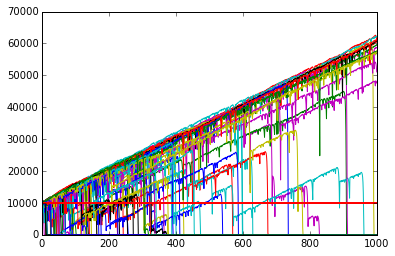

In [15]:
use_trials()

In [16]:
np.random.seed(123)
random.seed(123)

survived: 13.0%
profited: 13.0%
ave profit: -$243900.00
max profit: $52200.00


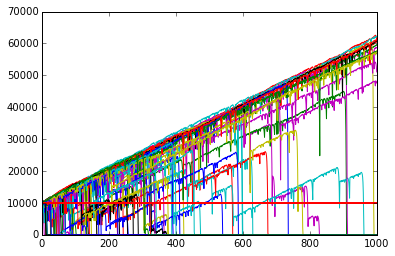

In [17]:
use_trials()

In [18]:
np.random.seed(123)
random.seed(123)

survived: 15.0%
profited: 14.0%
ave profit: -$263500.00
max profit: $54000.00


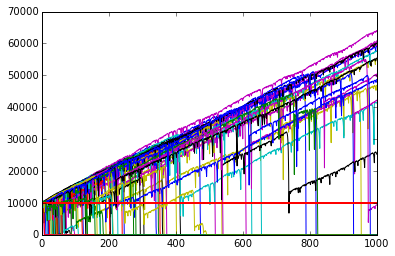

In [19]:
use_vtrials()

In [21]:
np.random.seed(123)
random.seed(123)
%timeit -n 10 use_monte()

np.random.seed(123)
random.seed(123)
%timeit -n 10 use_vmonte()

10 loops, best of 3: 96.6 ms per loop
10 loops, best of 3: 2.5 s per loop


In [9]:
import profiling
import roll

%timeit roll.dice(1000)
%timeit roll.many_die(1000)

profiling.profile('roll.dice(1000)')
profiling.profile('roll.many_die(1000)')

1000 loops, best of 3: 538 µs per loop
100 loops, best of 3: 2.16 ms per loop
         1018 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 function_base.py:1672(__call__)
        1    0.000    0.000    0.000    0.000 function_base.py:1702(_get_ufunc_and_otypes)
        1    0.000    0.000    0.001    0.001 function_base.py:1758(_vectorize_call)
        2    0.000    0.000    0.000    0.000 numeric.py:394(asarray)
        1    0.000    0.000    0.001    0.001 roll.py:26(dice)
     1001    0.000    0.000    0.000    0.000 roll.py:9(win)
        1    0.000    0.000    0.000    0.000 {isinstance}
        1    0.000    0.000    0.000    0.000 {len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {metho

In [22]:
%%file profile_strategy.py
"""
betting strategies

forked from: http://pythonprogramming.net/dashboard/#tab_montecarloyo
"""

import roll
import numpy as np
import random


@profile
def trajectory(N=1):
    """convert dice rolls True/False to +1/-1"""
    results = np.empty(N+1)
    results[0] = 0
    results[1:] = np.asarray(roll.dice(N), int)
    record = results[1:]
    record[record == 0] = -1
    return results


@profile
def clip(x):
    """clip all values to zero upon first non-positive value"""
    x[x <= 0] = 0
    x[np.logical_not(np.logical_and.accumulate(x))] = 0
    return x


@profile
def vsimple(funds, initial_wager, wager_count, *args):
    '''Simple (numpy) bettor, betting the same amount each time.'''
    wager = initial_wager
    return clip(funds + (wager * np.cumsum(trajectory(wager_count))))


@profile
def vmartingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    wager = float(initial_wager)

    history = trajectory(wager_count)
    won = history.copy()
    won[1:] = history[:-1] > -1  # also treat '0' as 'win'

    # upon losing, double the bet
    # upon winning, bet the initial
    # can't bet more than you have
    for i,w in enumerate(won[1:]):
        n = i+1
        if w:
            won[n] = 1
            continue
        scale = wscale if history[i] == 1 else lscale
        won[n] = min(scale * won[i], funds/wager + sum(history[:n] * won[:n]))
    '''# calculation looks something like this...
    history = [0, 1, 1,-1,-1, 1, 1,-1,-1,-1]
        won = [0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
        bet = [0, 1, 1, 1, 2, 4, 1, 1, 2, 4]
      value = [0, 1, 1,-1,-2, 4, 1,-1,-2,-4]
    '''
    return clip(funds + (wager * np.cumsum(history * won)))


@profile
def simple(funds, initial_wager, wager_count, *args):
    '''
    Simple bettor, betting the same amount each time.
    '''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    while currentWager <= wager_count:
        if roll.die():
            value += wager
            history[currentWager] = value
        else:
            value -= wager
            if value <= 0:
                break
            history[currentWager] = value
        currentWager += 1

    return history


@profile
def martingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    '''martingale bettor, "doubling-down" (actually, "*scaling-down")'''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)

    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if roll.die():
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            if roll.die():
                wager = previousWagerAmount * wscale
                if (value - wager) < 0:
                    wager = value
                value += wager
                history[currentWager] = value
                wager = initial_wager
                previousWager = 'win'
            else:
                wager = previousWagerAmount * lscale
                if (value - wager) < 0:
                    wager = value
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history



def run_trajectory(initial_funds, initial_bets, number_bets, *args, **kwds):
    "plot the rolls of a 100-sided die for all strategies"
    bettors = (simple, martingale, vsimple, vmartingale)
    for bettor in bettors:
        np.random.seed(123)
        random.seed(123)
        _ = bettor(initial_funds, initial_bets, number_bets, *args, **kwds)
    return


if __name__ == '__main__':
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    W = L = 2

    run_trajectory(initial_funds, initial_bet, number_bets, W,L)


# EOF

Overwriting profile_strategy.py


In [23]:
%%bash
kernprof -lv profile_strategy.py

Wrote profile results to profile_strategy.py.lprof
Timer unit: 1e-06 s

Total time: 0.002013 s
File: profile_strategy.py
Function: trajectory at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           @profile
    13                                           def trajectory(N=1):
    14                                               """convert dice rolls True/False to +1/-1"""
    15         2           13      6.5      0.6      results = np.empty(N+1)
    16         2            5      2.5      0.2      results[0] = 0
    17         2         1926    963.0     95.7      results[1:] = np.asarray(roll.dice(N), int)
    18         2            2      1.0      0.1      record = results[1:]
    19         2           67     33.5      3.3      record[record == 0] = -1
    20         2            0      0.0      0.0      return results

Total time: 5.8e-05 s
File: profile_strategy.py
Function: clip at line 23

Line #      Hits   

In [24]:
%%file profile_strategy2.py
"""
betting strategies

forked from: http://pythonprogramming.net/dashboard/#tab_montecarloyo
"""

import roll
import numpy as np
import random


#@profile
def trajectory(N=1):
    """convert dice rolls True/False to +1/-1"""
    results = np.empty(N+1)
    results[0] = 0
    results[1:] = np.asarray(roll.dice(N), int)
    record = results[1:]
    record[record == 0] = -1
    return results


#@profile
def clip(x):
    """clip all values to zero upon first non-positive value"""
    x[x <= 0] = 0
    x[np.logical_not(np.logical_and.accumulate(x))] = 0
    return x


#@profile
def vsimple(funds, initial_wager, wager_count, *args):
    '''Simple (numpy) bettor, betting the same amount each time.'''
    wager = initial_wager
    return clip(funds + (wager * np.cumsum(trajectory(wager_count))))


#@profile
def vmartingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    wager = float(initial_wager)

    history = trajectory(wager_count)
    won = history.copy()
    won[1:] = history[:-1] > -1  # also treat '0' as 'win'

    # upon losing, double the bet
    # upon winning, bet the initial
    # can't bet more than you have
    for i,w in enumerate(won[1:]):
        n = i+1
        if w:
            won[n] = 1
            continue
        scale = wscale if history[i] == 1 else lscale
        won[n] = min(scale * won[i], funds/wager + sum(history[:n] * won[:n]))
    '''# calculation looks something like this...
    history = [0, 1, 1,-1,-1, 1, 1,-1,-1,-1]
        won = [0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
        bet = [0, 1, 1, 1, 2, 4, 1, 1, 2, 4]
      value = [0, 1, 1,-1,-2, 4, 1,-1,-2,-4]
    '''
    return clip(funds + (wager * np.cumsum(history * won)))


@profile
def simple(funds, initial_wager, wager_count, *args):
    '''
    Simple bettor, betting the same amount each time.
    '''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)
    roll_die = roll.dice(wager_count+1)


    currentWager = 1

    while currentWager <= wager_count:
        if roll_die[currentWager]:
            value += wager
            history[currentWager] = value
        else:
            value -= wager
            if value <= 0:
                break
            history[currentWager] = value
        currentWager += 1

    return history


@profile
def martingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    '''martingale bettor, "doubling-down" (actually, "*scaling-down")'''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)
    roll_die = roll.dice(wager_count+1)


    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if roll_die[currentWager]:
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            if roll_die[currentWager]:
                wager = previousWagerAmount * wscale
                if (value - wager) < 0:
                    wager = value
                value += wager
                history[currentWager] = value
                wager = initial_wager
                previousWager = 'win'
            else:
                wager = previousWagerAmount * lscale
                if (value - wager) < 0:
                    wager = value
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history



def run_trajectory(initial_funds, initial_bets, number_bets, *args, **kwds):
    "plot the rolls of a 100-sided die for all strategies"
    bettors = (simple, martingale, vsimple, vmartingale)
    for bettor in bettors:
        np.random.seed(123)
        random.seed(123)
        _ = bettor(initial_funds, initial_bets, number_bets, *args, **kwds)
    return


if __name__ == '__main__':
    initial_funds = 10000
    initial_bet = 100
    number_bets = 1000
    W = L = 2

    run_trajectory(initial_funds, initial_bet, number_bets, W,L)


# EOF

Overwriting profile_strategy2.py


In [25]:
%%bash
kernprof -lv profile_strategy2.py

Wrote profile results to profile_strategy2.py.lprof
Timer unit: 1e-06 s

Total time: 0.003621 s
File: profile_strategy2.py
Function: simple at line 65

Line #      Hits         Time  Per Hit   % Time  Line Contents
    65                                           @profile
    66                                           def simple(funds, initial_wager, wager_count, *args):
    67                                               '''
    68                                               Simple bettor, betting the same amount each time.
    69                                               '''
    70         1            3      3.0      0.1      value = funds
    71         1            0      0.0      0.0      wager = initial_wager
    72         1            1      1.0      0.0      wager_count = int(wager_count)
    73         1           10     10.0      0.3      history = [funds] + [0]*(wager_count)
    74         1          989    989.0     27.3      roll_die = roll.dice(wager_count+1)
 

In [26]:
%%file strategy.py
"""
betting strategies

forked from: http://pythonprogramming.net/dashboard/#tab_montecarloyo
"""

import roll


def simple(funds, initial_wager, wager_count, *args):
    '''
    Simple bettor, betting the same amount each time.
    '''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)
    roll_die = roll.dice(wager_count+1)


    currentWager = 1

    while currentWager <= wager_count:
        if roll_die[currentWager]:
            value += wager
            history[currentWager] = value
        else:
            value -= wager
            if value <= 0:
                break
            history[currentWager] = value
        currentWager += 1

    return history


def martingale(funds, initial_wager, wager_count, wscale=1, lscale=1):
    '''martingale bettor, "doubling-down" (actually, "*scaling-down")'''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)
    roll_die = roll.dice(wager_count+1)


    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if roll_die[currentWager]:
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            if roll_die[currentWager]:
                wager = previousWagerAmount * wscale
                if (value - wager) < 0:
                    wager = value
                value += wager
                history[currentWager] = value
                wager = initial_wager
                previousWager = 'win'
            else:
                wager = previousWagerAmount * lscale
                if (value - wager) < 0:
                    wager = value
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history


def dAlembert(funds, initial_wager, wager_count, *args):
    '''d'Alembert bettor'''
    value = funds
    wager = initial_wager
    wager_count = int(wager_count)
    history = [funds] + [0]*(wager_count)
    roll_die = roll.dice(wager_count+1)


    currentWager = 1

    # since we'll be betting based on previous bet outcome #
    previousWager = 'win'

    # since we'll be doubling #
    previousWagerAmount = initial_wager

    while currentWager <= wager_count:
        if previousWager == 'win':
            if wager == initial_wager:
                pass
            else:
                wager -= initial_wager
            if roll_die[currentWager]:
                value += wager
                history[currentWager] = value
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager
        elif previousWager == 'loss':
            wager = previousWagerAmount + initial_wager
            if (value - wager) < 0:
                wager = value
            if roll_die[currentWager]:
                value += wager
                history[currentWager] = value
                previousWager = 'win'
            else:
                value -= wager
                if value <= 0:
                    break
                history[currentWager] = value
                previousWager = 'loss'
                previousWagerAmount = wager

        currentWager += 1

    return history


# EOF

Overwriting strategy.py


In [28]:
np.random.seed(123)
random.seed(123)
import use_trials2
%timeit -n 10 use_trials2.use_monte()

10 loops, best of 3: 95.8 ms per loop
